## VQE for the Set of Partitioning Problem


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# here you need to put your folder path for functions and Instances_Benchmark
sys.path.append('')
file_folder = ''

In [ ]:
from _utility import *

# read the instance file
w, c, A = read_instance(file_folder + "6.1.txt")

# biulding the Hamiltonian
parameters = (w, c, A)
hamiltonian = build_hamiltonian(parameters)

# solving using Gurobi
solution = sp_gurobi(w, A)
ref_value = sp_objective(w, solution)

print("Solution:", solution)
print("ref_value:", ref_value)
print("Hamiltonian:", hamiltonian)

Solution: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
ref_value: 102.0
Hamiltonian: SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'IIIIII', 'ZIZIII', 'ZIIZII', 'ZIIIZI', 'ZIIIIZ', 'IZZIII', 'IZIZII', 'IZIIZI', 'IZIIIZ', 'ZIZIII', 'IZZIII', 'IIZZII', 'IIZIZI', 'IIZIIZ', 'ZIIZII', 'IZIZII', 'IIZZII', 'IIIZZI', 'IIIZIZ', 'ZIIIZI', 'IZIIZI', 'IIZIZI', 'IIIZZI', 'IIIIZZ', 'ZIIIIZ', 'IZIIIZ', 'IIZIIZ', 'IIIZIZ', 'IIIIZZ'],
              coeffs=[ -850.5 +0.j, -1396.5 +0.j, -1396.5 +0.j, -1374.  +0.j, -1750.5 +0.j,
 -1192.5 +0.j,  5124.  +0.j,   228.75+0.j,   228.75+0.j,   183.  +0.j,
   320.25+0.j,   320.25+0.j,   320.25+0.j,   366.  +0.j,   228.75+0.j,
   228.75+0.j,   320.25+0.j,   183.  +0.j,   228.75+0.j,   274.5 +0.j,
   228.75+0.j,   320.25+0.j,   183.  +0.j,   411.75+0.j,    91.5 +0.j,
   183.  +0.j,   366.  +0.j,   228.75+0.j,   411.75+0.j,   228.75+0.j,
   320.25+0.j,   228.75+0.j,   274.5 +0.j,    91.5 +0.j,   228.75+0.j])


In [3]:
# Estimador options
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

def save_results(step, parameters, mean, std):
    eval_count.append(step)
    values.append(mean)
    print(f"Run {run+1}: Step: {step} Expected value: {mean}", end="\r", flush=True)

seed = 50
algorithm_globals.random_seed = seed
optimizer = COBYLA(maxiter=10_000, tol=1e-6)
algorithm_globals.random_seed = seed

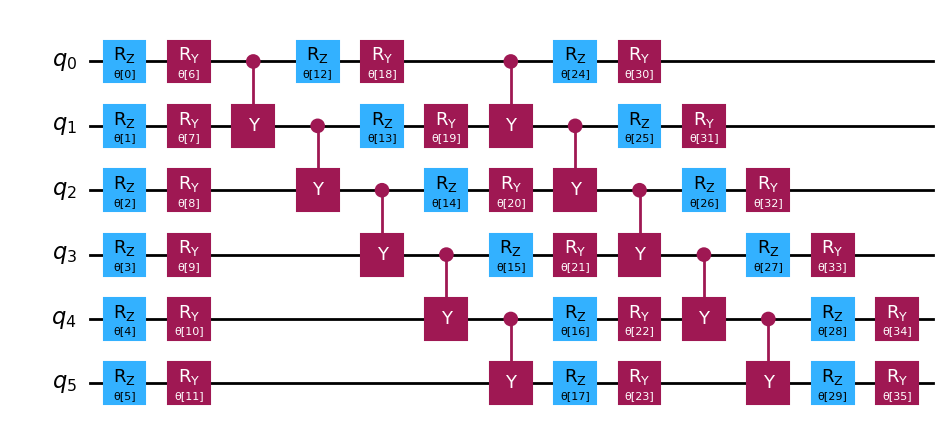

In [4]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(hamiltonian.num_qubits, entanglement='linear', reps= 2, rotation_blocks=["rz", "ry"], entanglement_blocks="cy")
ansatz.decompose().draw('mpl', fold=-1)

In [ ]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from qiskit.primitives import Estimator

## for a noise-free test use this part
noiseless_estimator = Estimator(options={"seed":seed, "shots": 1024, "seed_transpiler": seed})


## for a noise model test use this one
noise_model = NoiseModel()
coupling_map = [(i, i+1) for i in range(hamiltonian.num_qubits - 1)]

# setting error to the gate 'cy'
error = depolarizing_error(0.01, 2)
noise_model.add_quantum_error(error, ['cy'], [0, 5])
basis_gates = noise_model.basis_gates

noisy_estimator = AerEstimator(
                    backend_options={
                        "coupling_map": coupling_map,
                        "noise_model": noise_model,
                        "basis_gates":basis_gates
                    },
                    run_options={"seed": seed, "shots": 1024},
                    transpile_options={"seed_transpiler": seed},
                    )

---------------------------------------
Instance for 6-qubits  Ref value: 102.0
---------------------------------------


Minimum values for each run: [102.11239718122695, 102.02342161966297, 102.00004921170468, 102.00265131186875, 1528.7049818918454, 102.00005181464667, 102.00005742731344]
Median of the minimum values: 102.00
Approximation ration: 1.00



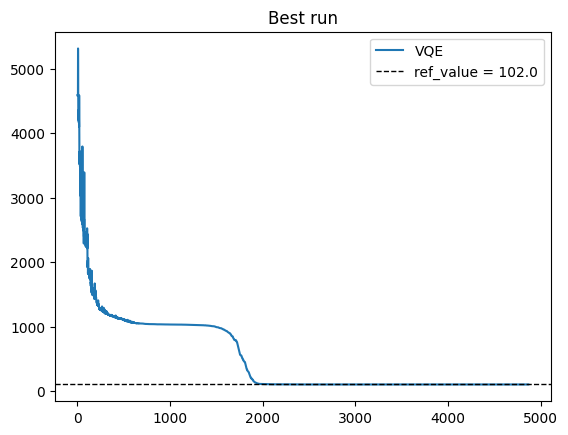

In [ ]:
from qiskit_algorithms import VQE

print("-"*39)
print(f'Instance for {hamiltonian.num_qubits}-qubits  Ref value: {ref_value}')
print("-"*39)

# initialize a dictionary to store results for each run
results_dict = {}

runs = 7
for run in range(runs):
    values = []
    eval_count = []
    
    # execute VQE and save the result
    vqe = VQE(noiseless_estimator, ansatz, optimizer=optimizer, callback=save_results)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    
    # store the result and min_value in the dictionary
    results_dict[run] = {
        "values": values,
        "min_value": result.optimal_value,
        "optimal_parameters": result.optimal_parameters
    }

# cxtract all min_values for easier processing
min_values = [results_dict[i]["min_value"] for i in range(runs)]

# calculate the median of the minimum values and the approx ration
median_min_value = np.median(min_values)
ratio =  ref_value / median_min_value 

index_best_run = min_values.index(min(min_values))

# Results
print("Minimum values for each run:", min_values)
print(f"Median of the minimum values: {median_min_value:.2f}")
print(f"Approximation ration: {ratio:.2f}\n")

# plot the best run
plt.title("Best run")
plt.plot(results_dict[index_best_run]['values'], label="VQE")
plt.axhline(y=float(ref_value), color='black', linestyle='--', label=f'ref_value = {ref_value}', linewidth=1)
plt.legend()
plt.show()



Gurobi Optimal Solution: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
VQE Solution: 110000


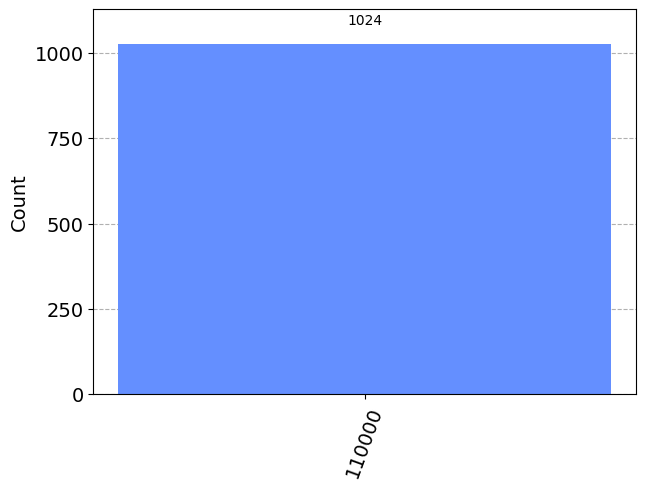

In [9]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

best_parameters = results_dict[index_best_run]['optimal_parameters']
optmal_circuit = result.optimal_circuit.assign_parameters(best_parameters).decompose()
optmal_circuit.measure_all()

sim = AerSimulator()
job = sim.run(circuits=optmal_circuit , shots=1024)
quantum_solution = job.result().get_counts()

key_with_max_value = max(quantum_solution, key=quantum_solution.get)

print("Gurobi Optimal Solution:", solution)
print("VQE Solution:", key_with_max_value)
plot_histogram(quantum_solution)